Please download the data from here in the github page. Note that 2002-2005 data is from Amelung etal. 2007.

In [1]:
import h5py
import numpy as np
from numpy import pi
from mintpy.utils import readfile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm, pyproj
import scipy.io as sio
from matplotlib.colors import LinearSegmentedColormap, LightSource
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage.filters import gaussian_filter
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


Functions to read data

In [19]:
def get_basemap(dem_file):
    dem, atr_dem = readfile.read(dem_file)
    geo_box=[]; 
    geo_box.append(np.float(atr_dem['X_FIRST']));geo_box.append(np.float(atr_dem['Y_FIRST']));
    geo_box.append(geo_box[0]+np.int(atr_dem['WIDTH'])*np.float(atr_dem['X_STEP']));
    geo_box.append(geo_box[1]+np.int(atr_dem['FILE_LENGTH'])*np.float(atr_dem['Y_STEP']));
    map_projection='cyl'; ls = LightSource(azdeg=315, altdeg=45)
    dem_shade = ls.shade(dem, vert_exag=1.0, cmap=plt.cm.gray, vmin=-20000, vmax=np.nanmax(dem)+2500)
    return dem_shade,geo_box

def get_geodmod_3Ddata(name,component_flag):
    enu_data=sio.loadmat(name,squeeze_me=True)
    #print enu_data
    insar_data=enu_data['enu']['data'][:];
    rows=np.shape(insar_data[0])[0]
    cols=np.shape(insar_data[0])[1]
    geo_box=[1,2,3,4];
    geo_box[0]=enu_data['enu']['x_first'][0];
    geo_box[2]=geo_box[0]+cols*enu_data['enu']['x_step'][0]
    geo_box[1]=enu_data['enu']['y_first'][0]
    geo_box[3]=geo_box[1]+rows*enu_data['enu']['y_step'][0];
    if component_flag==0:
        return insar_data[0],geo_box
    else:
        return insar_data[2],geo_box

def get_data(insar_vel_map):
    data,atr=readfile.read(data_file);
    if atr['UNIT'] == 'radian': 
        data=data*(float(atr['WAVELENGTH'])/(-4*pi));
    data_box=[];
    data_box.append(np.float(atr['X_FIRST']));data_box.append(np.float(atr['Y_FIRST']));
    data_box.append(data_box[0]+np.int(atr['WIDTH'])*np.float(atr['X_STEP']));
    data_box.append(data_box[1]+np.int(atr['LENGTH'])*np.float(atr['Y_STEP']));
    return data,data_box

#DEM
dem_file='../InSAR_data/demGeo.h5'
dem_shade,geo_box=get_basemap(dem_file)
#Faults and coast lines
lines=sio.loadmat('../InSAR_data/hawaii_lines_new.mat',squeeze_me=True);

#InSAR data converted to East-West and Vertical components using Mintpy
data_dir='East-West_vertical_files/'
file_name=['2002-2005.mat','2014_2015.unw','2015_2018.unw','2018_2020.unw']
mask_file=data_dir+'mask.h5'

Plot contour figures. Color scale factors are chosen visually to illustrate the deformation shift between timeperiods

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


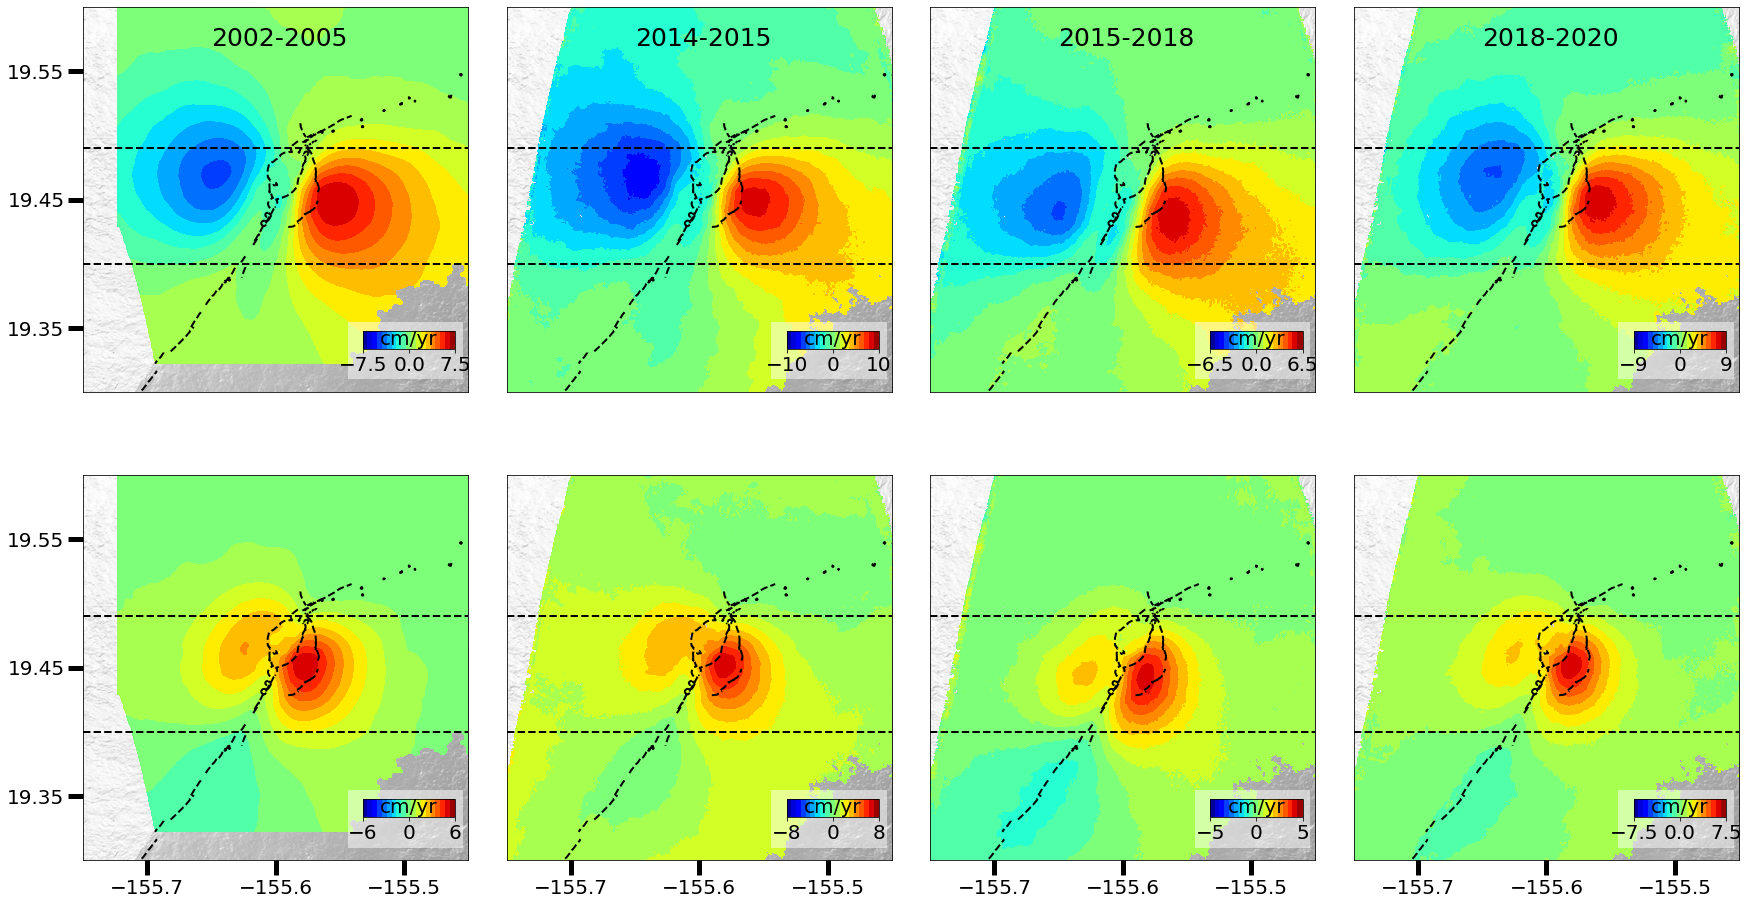

In [20]:
from matplotlib.colors import Normalize
cols=len(file_name)
fig,axes= plt.subplots(2,cols,figsize=(20,10),sharex=True, sharey=True);
fig.subplots_adjust(left=0.5, bottom=1.9, right=1.65, top=3.20, wspace=0.1, hspace=0.001)
nos=['2002-2005','2014-2015','2015-2018','2018-2020'];

factor=[[7.5,10.0,6.5,9.0],
        [6.0,8.0,5.0,7.5]];

for i in range(2):
    for j in range(cols):
        ax=axes[i,j];ax.tick_params(labelsize=20);
        if i==0:
            data_file=data_dir+'hz_'+file_name[j];
        elif i==1:
            data_file=data_dir+'up_'+file_name[j];
        else:
            print('Error')
        if data_file.endswith('.mat'):
            data,data_box=get_geodmod_3Ddata(data_file,i);data=data*100;
        else:
            data,data_box=get_data(data_file);data=data*100;
        if i==0:
            ax.text(-155.65,19.57,nos[j],fontsize=25);
            #ax.text(-155.66,19.27,1.5,fontsize=35)
            
        ax.tick_params(axis='x',length=0, width=0);ax.tick_params(axis='y',length=0, width=0);
        #plot DEM
        map_projection='cyl';
        m = Basemap(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
                    urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
                    projection= map_projection,\
                    resolution='c', area_thresh=1., suppress_ticks=False, ax=ax);
        m.imshow(dem_shade, origin='upper', interpolation='spline16');
        m2 = Basemap(llcrnrlon=data_box[0], llcrnrlat=data_box[3],\
                     urcrnrlon=data_box[2], urcrnrlat=data_box[1],\
                     projection= map_projection,\
                     resolution='c', area_thresh=1., suppress_ticks=False, ax=ax);
        
        #filter and make contorus
        length,width=np.shape(data);
        lons=np.linspace(data_box[0],data_box[2],width);
        lats=np.linspace(data_box[1],data_box[3],length);
        levels=np.linspace(-factor[i][j],factor[i][j],20)
        sigma=0.8
        data = gaussian_filter(data, sigma);
        h5file=h5py.File(mask_file,'r')
        mask_data=h5file['mask'][:];
        if j in [1,2,3]:
            data[mask_data == 0] = np.nan;
        val= (np.nanmax(data)-np.nanmin(data));

        img1= ax.contourf(lons,lats,data,levels=levels,cmap='jet')
        ax.plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2);
        
        #customize plot
        if i==1:
            ax.tick_params(axis='x',length=15, width=5); 
        if j==0:
            ax.tick_params(axis='y',length=15, width=5); 
            
        #adjust tick labels
        ax.set_ylim((19.3,19.6));ax.set_xlim((-155.75,-155.45))
        ax.set_yticks([19.35, 19.45, 19.55]);ax.set_xticks([-155.7,-155.6,-155.5]);
        cbbox = inset_axes(ax, '100%', '50%', loc='lower right',bbox_to_anchor=(0.7, 0.02, 0.3, 0.3),bbox_transform=ax.transAxes)
        [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
        cbbox.set_xticklabels([]);cbbox.set_yticklabels([]);
        cbbox.tick_params(axis='both', left='off', top='off', right='off', bottom='off', 
                          labelleft='off', labeltop='off', labelright='off', labelbottom='off',
                         length=0,width=0);
        cbbox.set_facecolor([1,1,1,0.5])
        axins1 = inset_axes(ax,width="80%",height="15%",loc='lower right',bbox_to_anchor=(0.68, 0.1, 0.3, 0.3),bbox_transform=ax.transAxes)
        axins1.tick_params(labelsize=20);
        cbar=fig.colorbar(img1, cax=axins1, orientation='horizontal',ticks=[-factor[i][j],0,factor[i][j]]);
        cbar.set_label('cm/yr', rotation=0,labelpad=-45,size=20)#
        
        #add horizontal lines
        axlin1=19.40;axlin2=19.49
        ax.axhline(axlin1,color='black',linestyle='--',linewidth=2);
        ax.axhline(axlin2,color='black',linestyle='--',linewidth=2);

            
#Save figure
#plt.savefig('Hz_Up_2002_2020.pdf',dpi=500,bbox_inches='tight',transparent='True')